In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
from os.path import expanduser

from imagemks.rw import rwformat

def vis(A):
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.imshow(A, cmap='gray')
    plt.show(fig)

In [14]:
# Importing general libraries
import numpy as np
import scipy.ndimage as ndi
import pandas as pd

# Importing specific functions
from skimage.morphology import remove_small_objects, watershed
from skimage.feature import corner_peaks
from skimage.segmentation import relabel_sequential
from skimage.measure import regionprops
from skimage.color import label2rgb

# Importing ImageMKS functions
from imagemks.filters import fftgauss, local_avg
from imagemks.structures import donut
from imagemks.masking import maskfourier
from imagemks.visualization import make_boundary_image
from imagemks.workflows import visualize_fluor_cells, default_parameters

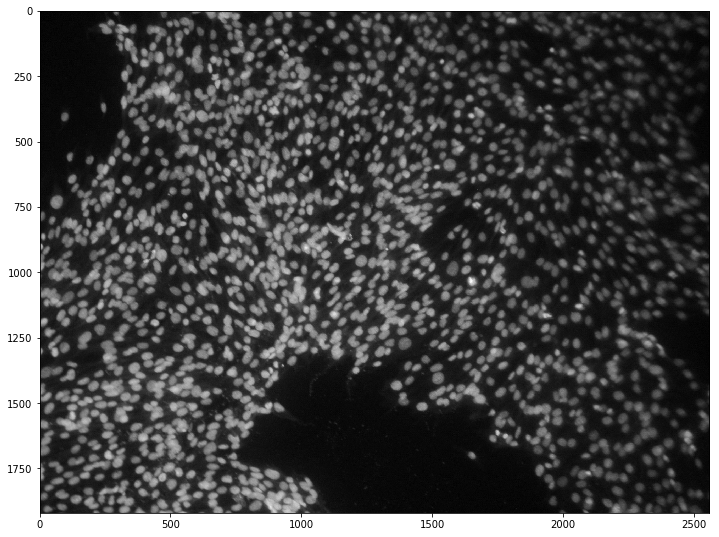

In [39]:
path_to_data = expanduser('~/Projects/Cells/Cells_Images_Original/')
zoomLev = 1
p = default_parameters('muscle')

nucs_loader = rwformat(path_to_data, prefix='b', ftype='.tif')
cyto_loader = rwformat(path_to_data, prefix='g', ftype='.tif')

n = 1

imgNuc = nucs_loader[n]
C = cyto_loader[n]


imgNuc = np.sum(np.array(imgNuc), axis=2)
C = np.sum(np.array(C), axis=2)

vis(imgNuc)

In [40]:
default_parameters('muscle')

{'smooth_size': 3,
 'intensity_curve': 2,
 'short_th_radius': 50,
 'long_th_radius': 600,
 'min_frequency_to_remove': 1,
 'max_frequency_to_remove': 500,
 'max_size_of_small_objects_to_remove': 300,
 'power_adjust': 1,
 'peak_min_distance': 10,
 'size_after_watershed_to_remove': 300,
 'cyto_local_avg_size': 200}

In [41]:
smooth_size = 3
intensity_curve=2
short_th_radius=50
long_th_radius=600
min_frequency_to_remove=1
max_frequency_to_remove=500
max_size_of_small_objects_to_remove=300
power_adjust=1
peak_min_distance=10
size_after_watershed_to_remove=300
cyto_local_avg_size=200

In [42]:
def _th_max_hist(img, num_bins=100):
    '''
    Method for thresholding at the max of a histogram.

    Parameters
    ----------
    img : An image of size (M,N).
    num_bins : Number of bins used for histogram. Optional.

    Returns
    -------
    A threshold value.
    '''

    minbin = np.amin(img)
    maxbin = np.amax(img)
    bins = np.linspace(minbin, maxbin, num_bins)
    hist, bins = np.histogram(img.ravel(), bins = bins)

    bins_mid = (bins[1:] + bins[:-1])/2
    big_peak = bins_mid[np.argmax(hist)]
    th = 0.5 + big_peak

    return th


def _gen_marks(label_img):
    props = regionprops(label_img)
    markers = np.zeros(label_img.shape)
    label_val = 1

    for i in props:
        x, y = i.centroid
        x = int(round(x))
        y = int(round(y))
        markers[x,y] = label_val
        label_val += 1

    return markers

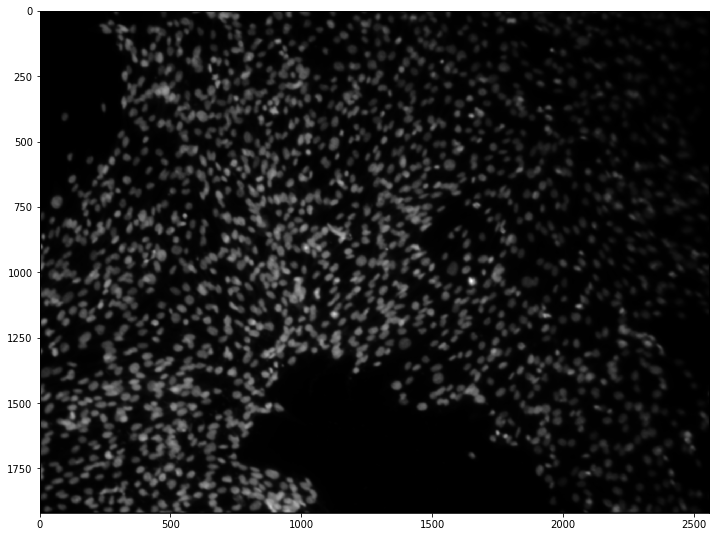

In [43]:
# Step 1: smoothing intensity values and smoothing out peaks
imgNuc = fftgauss(imgNuc, smooth_size)

# Step 2: contrast enhancement by scaling intensities (from 0-1) on a curve
########  many other methods can be implemented for this step which could benefit the segmentation
imgNuc = np.power(imgNuc/np.amax(imgNuc), intensity_curve)

vis(imgNuc)

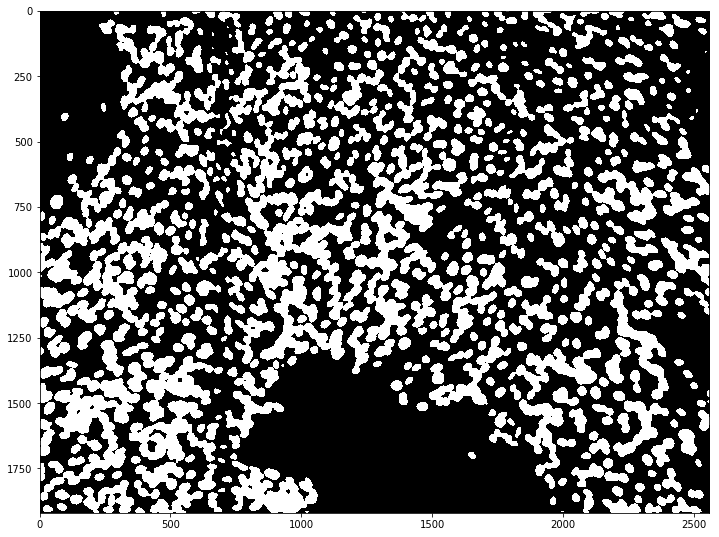

In [44]:
# Step 3: short range local avg threshold
th_short = imgNuc > local_avg(imgNuc, short_th_radius)[0]

# Step 4: long range local avg threshold
th_long = imgNuc > local_avg(imgNuc, long_th_radius)[0]

# Step 5: long && short
th_Nuc = (th_short*th_long)
del th_short, th_long

vis(th_Nuc)

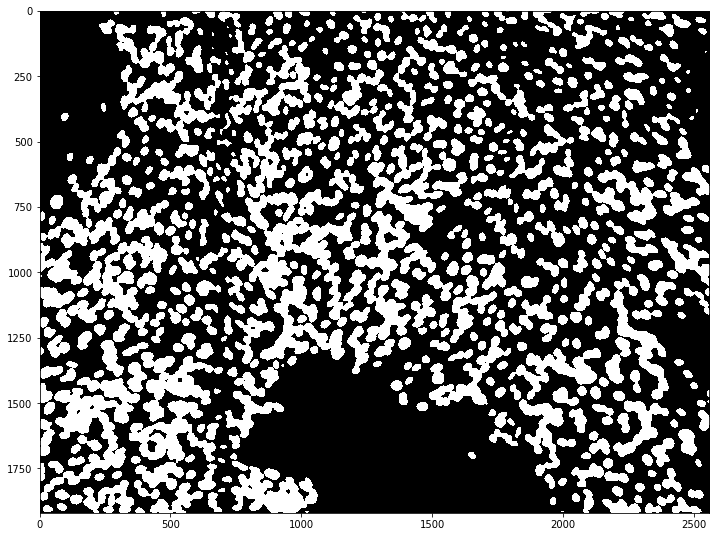

In [45]:
# Step 6: remove the short and long frequencies
mask = donut(r_outer=max_frequency_to_remove, r_inner=min_frequency_to_remove,
            size=th_Nuc.shape)
freq_Nuc = maskfourier(th_Nuc, mask)[0]

# Step 7: threshold the inverse fourier transform
th_m = _th_max_hist(freq_Nuc)
th_Nuc = freq_Nuc > th_m
del freq_Nuc

vis(th_Nuc)

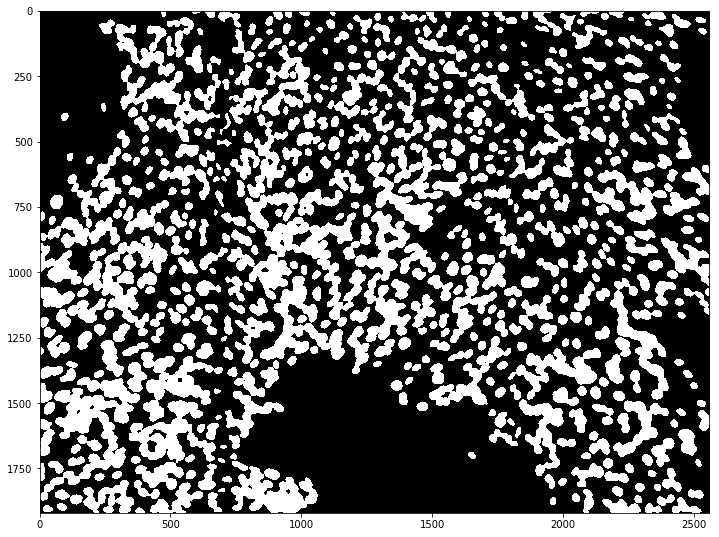

In [46]:
# Step 8: remove small objects
th_Nuc = remove_small_objects(th_Nuc, max_size_of_small_objects_to_remove * (zoomLev))

vis(th_Nuc)

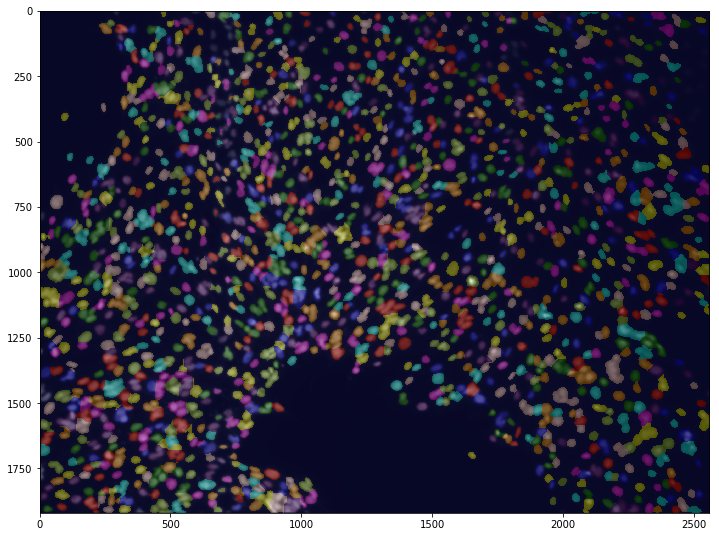

In [47]:
# Step 9: distance transform
distance = ndi.distance_transform_edt(th_Nuc)

# Step 10: mark the maxima in the distance transform and assign labels
peak_markers = corner_peaks(distance, min_distance=peak_min_distance, indices=False)
peak_markers = ndi.label(peak_markers)[0]

# Step 11: separate touching nuclei using the watershed markers
label_Nuc = watershed(th_Nuc, peak_markers, mask=th_Nuc)

vis(visualize_fluor_cells(label_Nuc, imgNuc)[0])

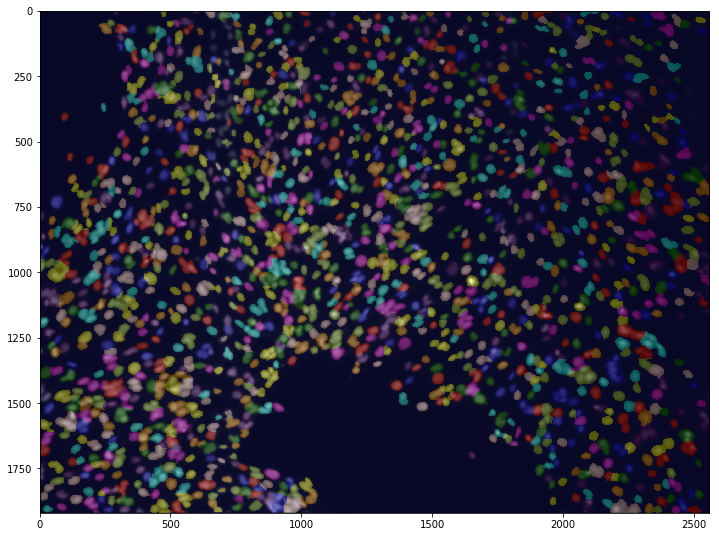

In [48]:
# Step 12: removing small regions after the watershed segmenation
sizes_matrix = ndi.sum(label_Nuc>0, label_Nuc, np.unique(label_Nuc))
rem_region = sizes_matrix < ( size_after_watershed_to_remove * (zoomLev) )
remove_pixel = rem_region[label_Nuc]
label_Nuc[remove_pixel] = 0

# Step 13: reassigning labels, so that they are continuously numbered
old_labels = np.unique(label_Nuc)
for i in range(len(old_labels)):
    label_Nuc[label_Nuc == old_labels[i]] = i
    
vis(visualize_fluor_cells(label_Nuc, imgNuc)[0])

In [ ]:
# Step 14: local threshold of the cytoskeleton
th_Cyto = imgCyto > local_avg(imgCyto, cyto_local_avg_size)[0]

# Step 15: generate relabeled markers from the nuclei centroids
new_markers = _gen_marks(label_Nuc)

# Step 16: watershed of cytoskeleton using new_markers
label_Cyto = watershed(th_Cyto, new_markers, mask=th_Cyto.astype(np.bool_))